## Credit to Fernando Torale Acosta and Vinicius Mikuni

# 1. Why Unfold

In [28]:
Image(filename="EventChain.png")

In [29]:
Image("Measurement.png")

## a) So then why not forward fold the theory?

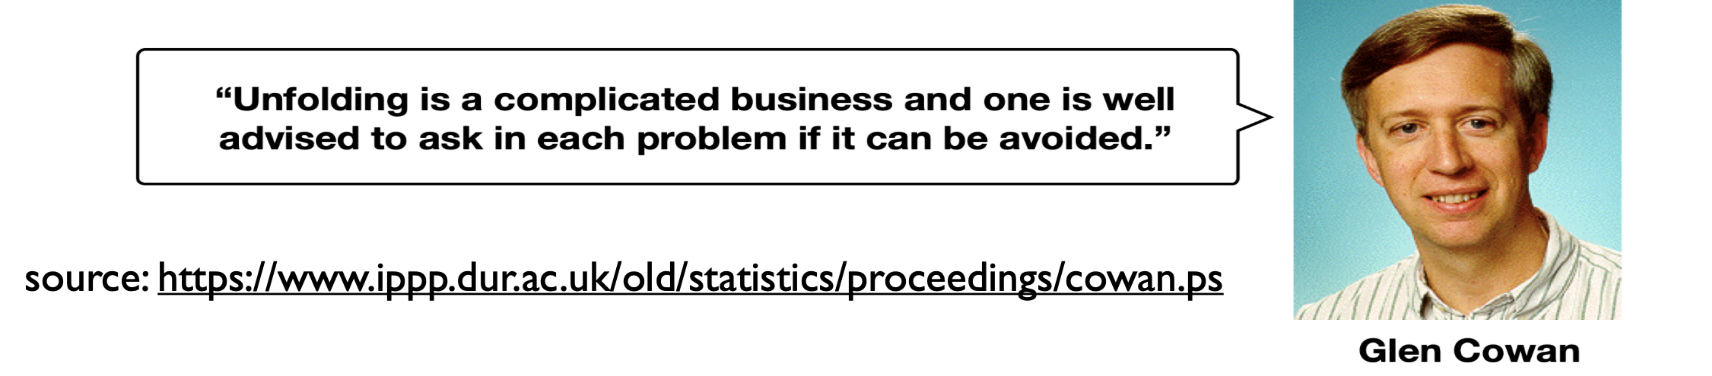

In [30]:
Image("GlennCowry.png")

- Comparisions between experiments (see Amanda Cooper-Sarkar (2018), Parton Distribution Functions - Experimental Overview)
    - It is useful to compare them directly in a theory independent manner
- A new theory is developed years later, the detector simulation is no longer available.
    - Even if the new theory is developed while the simulation is available, but the theorist doesn’t have access to the simulation….
- Forward folding requires full phase space predictions, rare for perturbative calculations
    - Typically we can only compute a limited set of kinematic distributions which sets limits on precision predictions
    - E.g. We can typically only calculate the jet pT and the rapidity, but the complete events are considerably more complicated
        - Can't forward fold only one calculated direction
        - Don't have a full Monte Carlo at hadron level

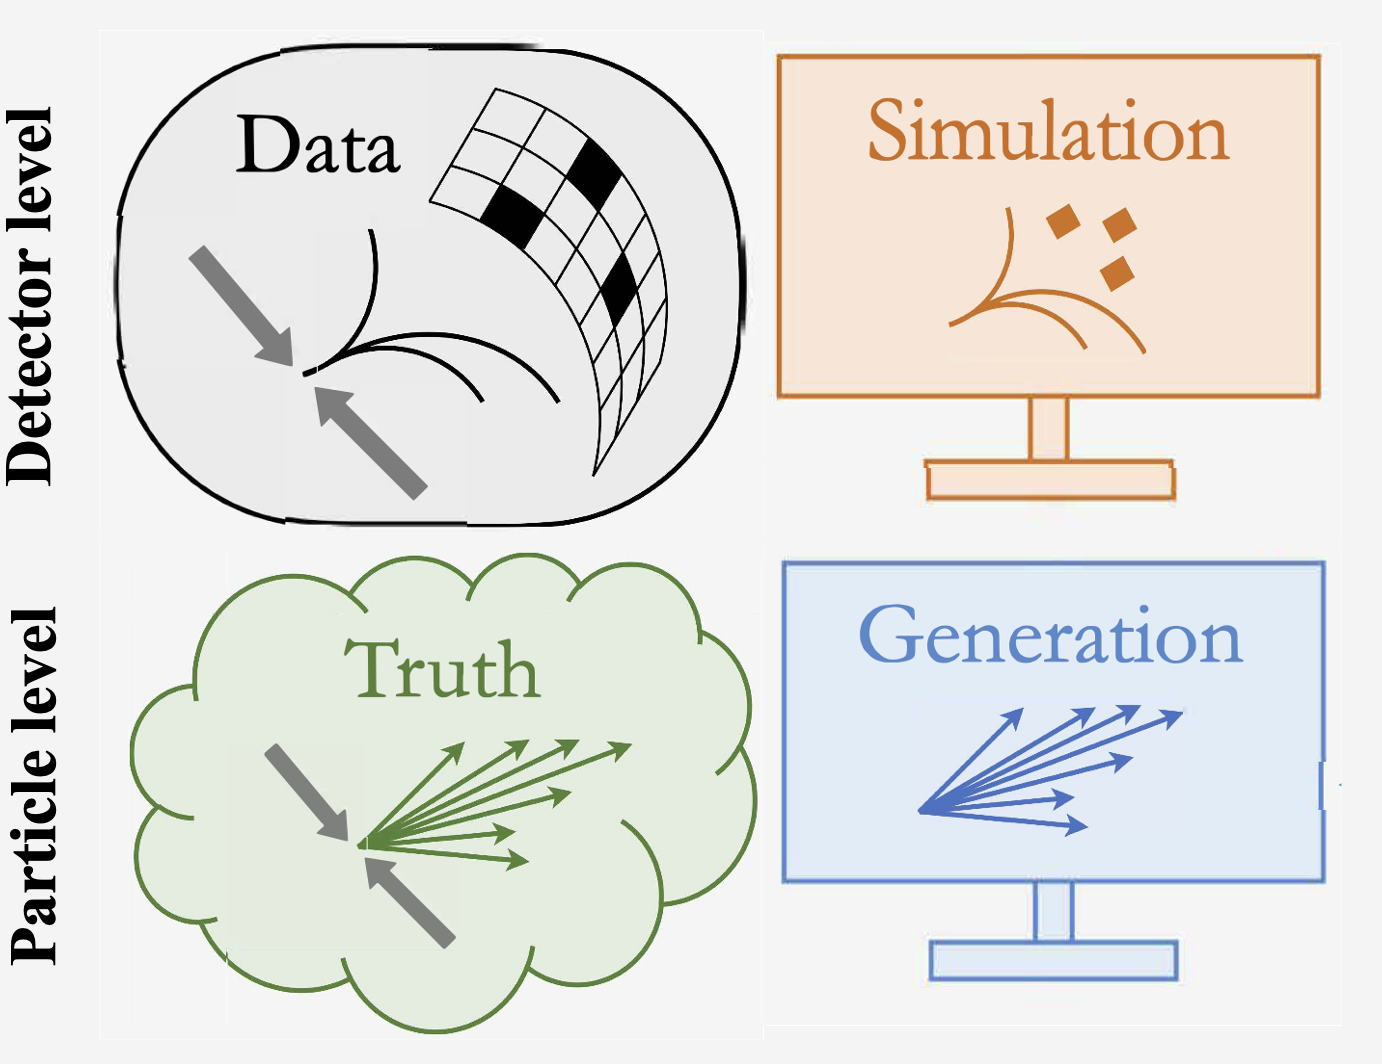

In [33]:
Image("Datasets.png", width = 500)

## b) Inverting the response matrix

The response matrix is highly singular, and the simple pseudoinverse means that nearby events at detector level can be unfolded into far apart events at particle level, but we have finite detector resolution, so the errors on our unfolded result would be unacceptable.

The method needs **regularization** to produce physical solutions

The most common method used in HEP is Iterative Bayesian Unfolding (also known as D’Agostini iteration or, in other fields, as Lucy—Richardson deconvolution)

IBU is inherently a binned method, and therefore, intrinsically introduces with binning artifacts into the analysis

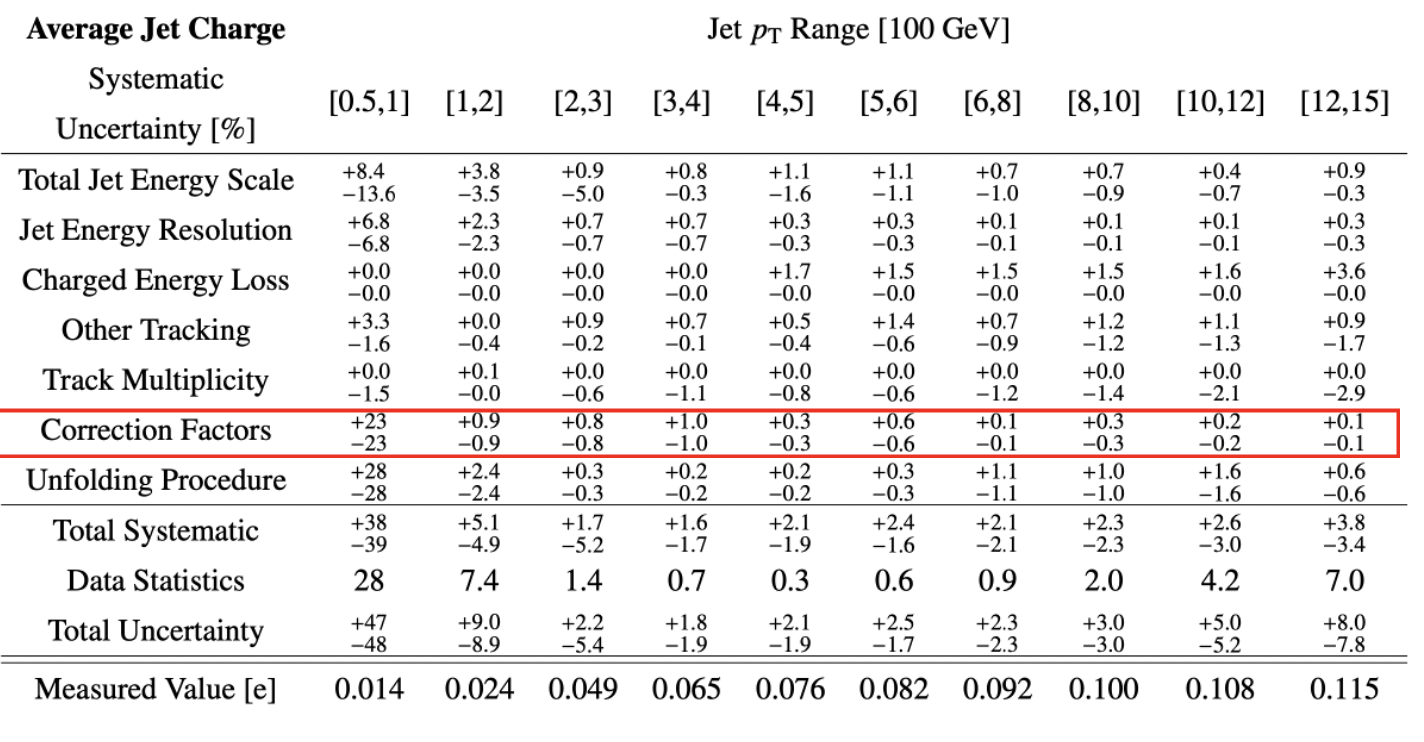

In [35]:
Image("CorrectionFactors.png")

### Omnifold is a machine learning based **unbinned** unfolding method

In [37]:
import numpy as np

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf
import energyflow as ef

from matplotlib import pyplot as plt
from IPython.display import Image

# [OmniFold](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.182001) Background

## 1. Overview

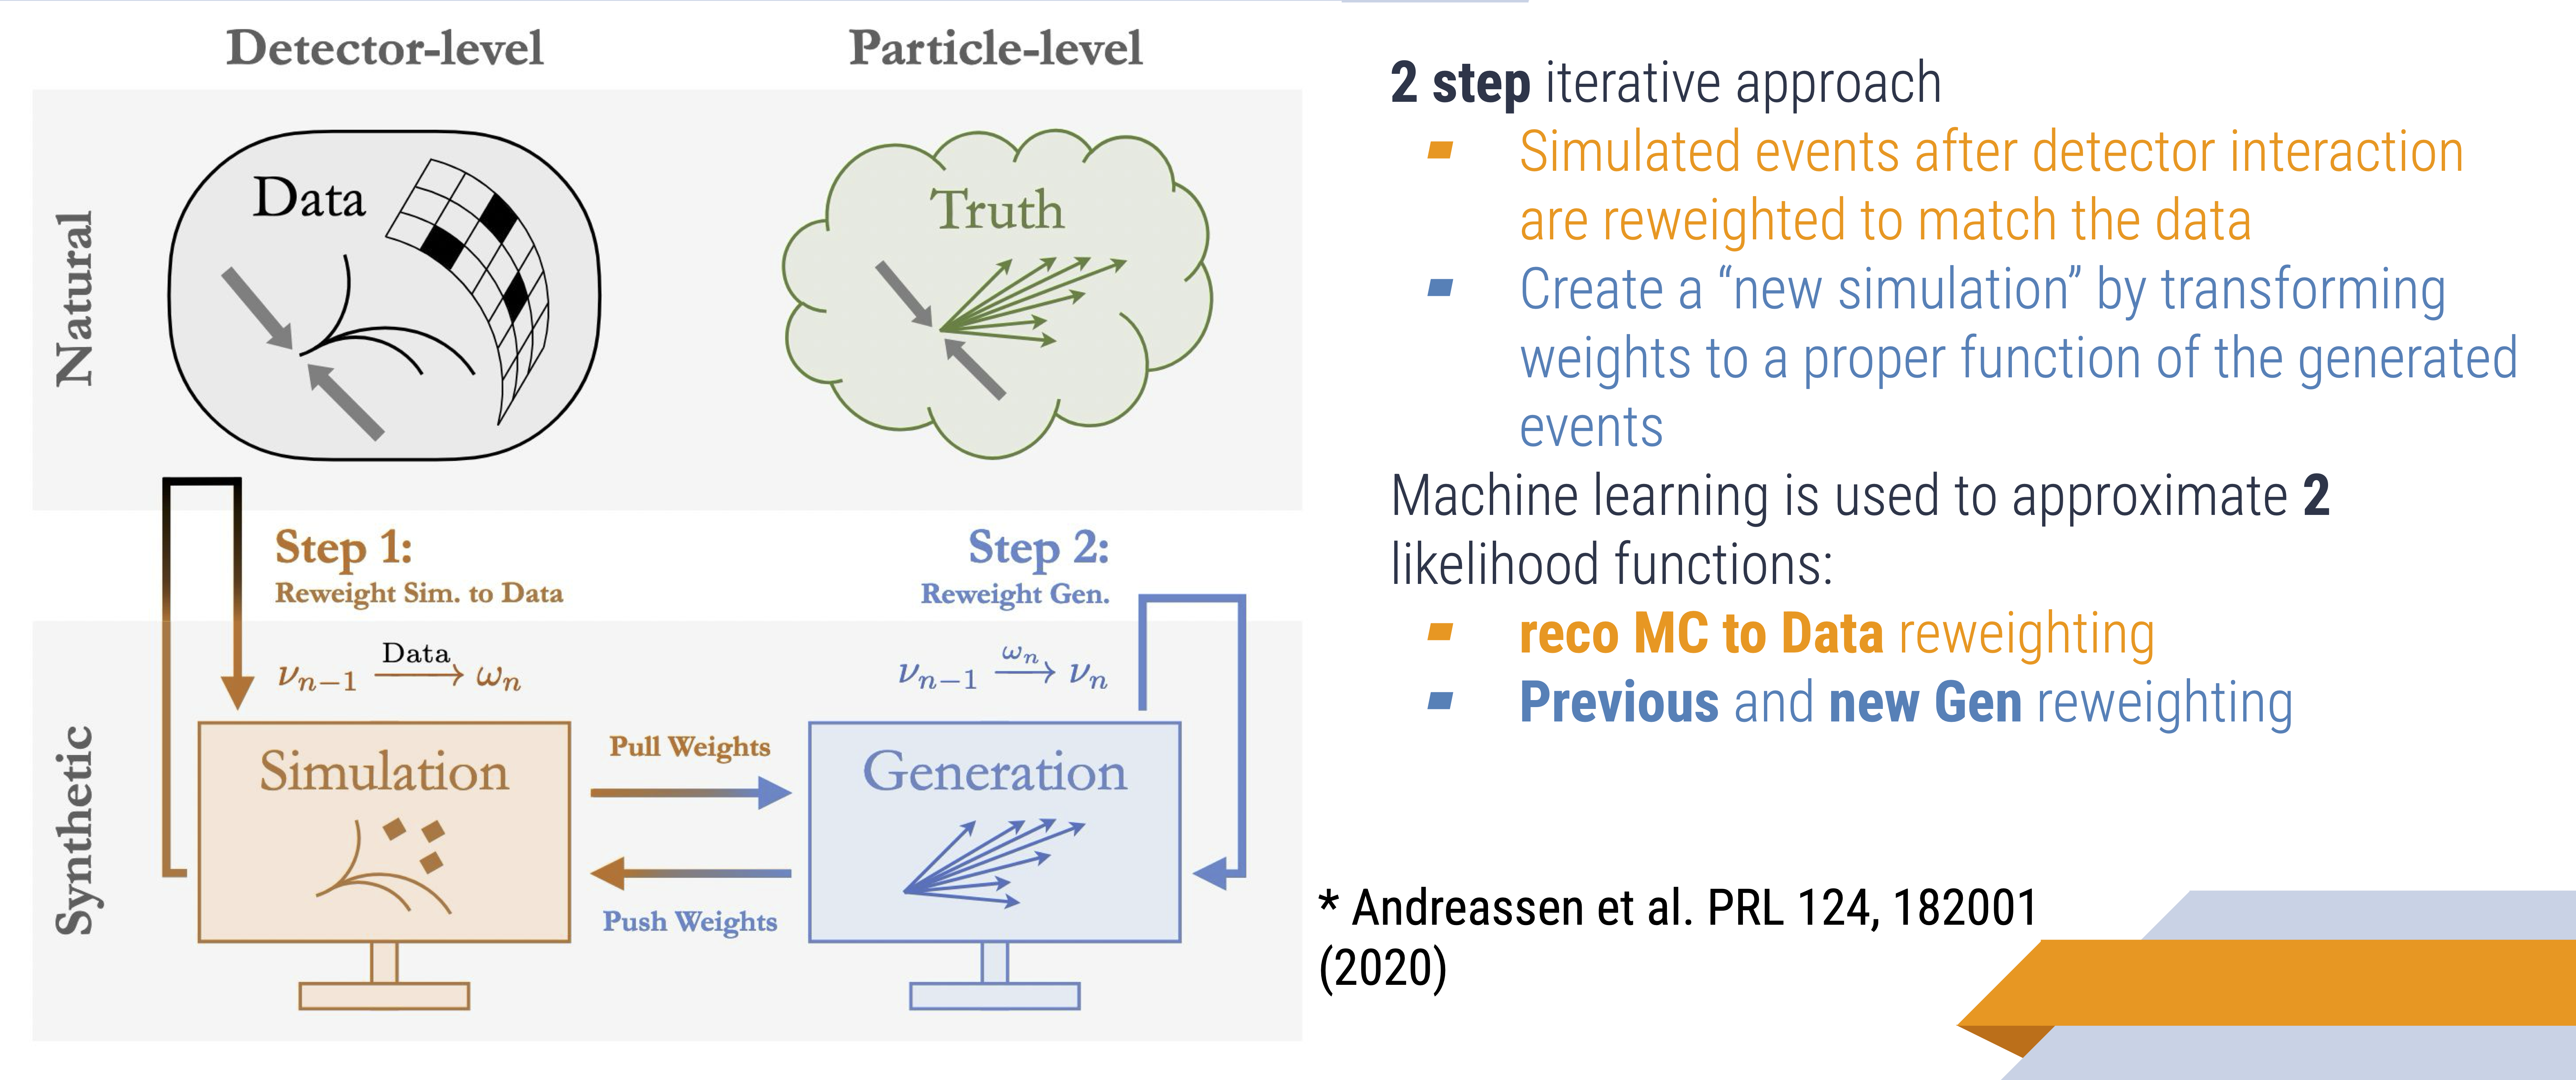

In [2]:
Image(filename='Omnifold_explained.png',width=1500) 

credit: Vinicius Mikuni

### Terms used for synthetic and natural data:

|   |   |   |
|---|---|---|
|Synthetic Generator-Level Sim   | $\theta_{0,G}$  | Truth-Level Sim  |
|Synthetic Reconstruction-Level Sim   | $\theta_{0,S}$   | Full Reco-Level Sim  |
|Natural Reconstruction  | $\theta_\mathrm{unknown,S}$  | Observed Detector Data  |
|Natural Truth   |$\theta_\mathrm{unknown,G}$   | Nature  |





..

## 2. Maximum Liklehood Estimators:

### We train classifiers using `binary cross-entropy loss`:

### $L_{BCE}[f] = - \int dx \left( p_A(x) \log(f(x)) + p_B(x) \log(1 - f(x)) \right)$

### To find the extremum, differentiate with respect to $f(x)$ and set to 0:

### $\frac{\partial L}{\partial f} = - \frac{\partial}{\partial f} \left( p_A(x) \log(f(x)) + p_B(x) \log(1 - f(x)) \right) = - \int dx \left( \frac{p_A(x)}{f(x)} - \frac{p_B(x)}{1 - f(x)} \right)$

### $\frac{\partial L}{\partial f} = 0 \implies \frac{f(x)}{1 - f(x)} = \frac{p_A(x)}{p_B(x)}$

See [Mariel Pettee's talk](https://indico.cern.ch/event/1357972/contributions/5866599/attachments/2874123/5032886/2024-6-11%20Paris%20PHYSTAT%20Workshop%20--%20Unbinned%20Disc%20Unfolding.pdf) for more details!

### To this end, we define a `reweight` function, using the output of our classifier, $f(x)$:

In [3]:
# in this repo: omnifold.py L6:
def reweight(events, model, batch_size=10000):
    f = model.predict(events, batch_size=batch_size)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))

## 3. Some Pseudo-Code

#### for N_Iterations:

    Step 1: 
        - Train a classifer on data and reco-level sim
        - reweight classifier output
        - pull weights into step 2 to make 'new gen'
        
    Step 2:
        - Train a classifier on old gen and new gen
        - reweight classifier output
        - push weights, repeat step 1

## 4. Two Examples: Simple 1D Gaussian, and Pythia/Herwig with Delphes

### Z+Jet Pythia and Herwig w/ Delphes: [dataset link](https://zenodo.org/records/3548091)

- `jets` - The jet axis four vector, as ($p_\mathrm{Tjet}$, $y_\mathrm{jet}$, $\phi_\mathrm{jet}$, $m_\mathrm{jet}$)

- `particles` - The rescaled jet constituents ($p_\mathrm{T}$/100,$y−y_\mathrm{jet}$,$\phi−\phi_\mathrm{jet}$, fPID)

- `mults` - The constituent multiplicity of the jet.
- `lhas` - The Les Houches (β=1/2) angularity.
- `widths` - The jet width (β=1 angularity).
- `ang2s` - The β=2 angularity (note that this is very similar to the jet mass, but does not depend on particle masses).
- `tau2s` - The 2-subjettiness with β=1.
- `sdms` - The groomed mass with Soft Drop parameters zcut=0.1 and β=0.
- `zgs` - The groomed momentum fraction (same Soft Drop parameters as above).

___
___

# OmniFold Example 1: Simple 1D Gaussian [[Original Repo](https://github.com/hep-lbdl/OmniFold)]

In [4]:
N_Events = 10**5

In [5]:
#Synthetic
g_mu = 0.2
g_sig = 0.8

theta0_G = np.random.normal(g_mu,g_sig,N_Events)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta0_G])  # Detector smearing for synthetic sample

theta0 = np.stack([theta0_G, theta0_S], axis=1)

#Natural
u_mu = 0.0
u_sig = 1.0
theta_unknown_G = np.random.normal(u_mu,u_sig, N_Events)
theta_unknown_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta_unknown_G]) 

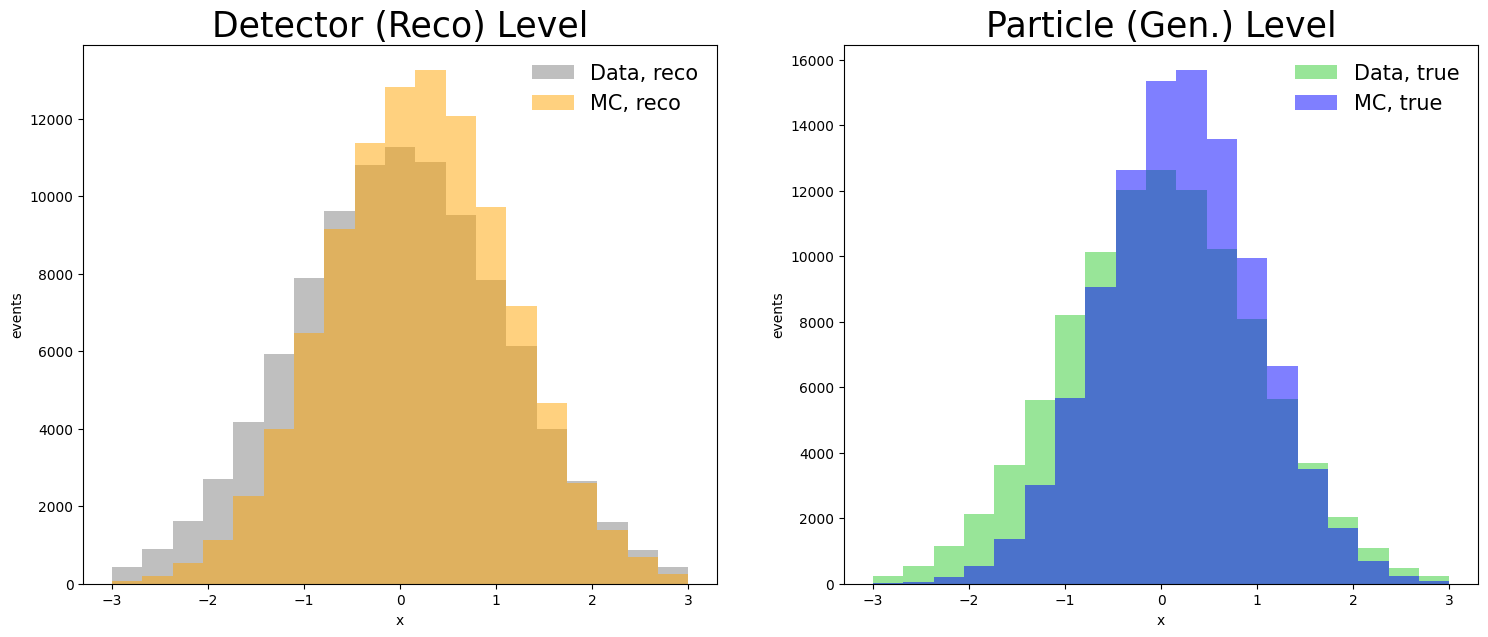

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18,7))


axes[0].set_title("Detector (Reco) Level",fontsize=25)
axes[1].set_title("Particle (Gen.) Level",fontsize=25)

axes[0].hist(theta_unknown_S,bins=np.linspace(-3,3,20),color='black',label="Data, reco",alpha=0.25)
axes[0].hist(theta0_S,bins=np.linspace(-3,3,20),color='orange',label="MC, reco",alpha=0.5)
axes[1].hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='limegreen',alpha=0.5,label="Data, true")
axes[1].hist(theta0_G,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")


for ax in np.ravel(axes):
    ax.set_xlabel("x")
    ax.set_ylabel("events")
    ax.legend(frameon=False,fontsize=15)

### Define the Model Architecture - A simple classifier!

In [7]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_gaus = Model(inputs=inputs, outputs=outputs)

### OmniFold

In [8]:
N_Iterations = 3
myweights = of.omnifold(theta0_G, theta0_S, theta_unknown_S, N_Iterations, model_gaus)

2024-06-17 13:37:46.351802: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [9]:
print(np.shape(myweights))

(3, 2, 100000)


1.018613506012559


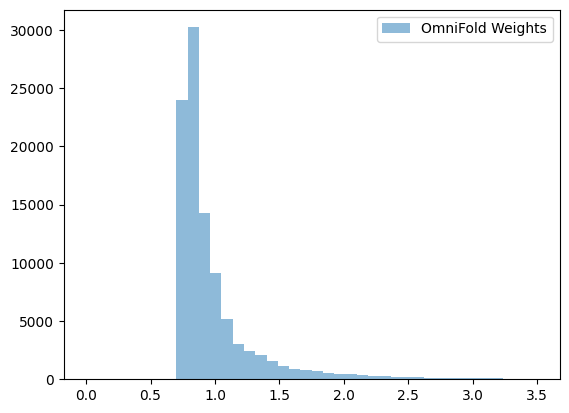

In [10]:
plt.hist(myweights[-1,1,:],label='OmniFold Weights',alpha=0.5,bins=np.linspace(0,3.5,41))
_ = plt.legend()
print(np.mean(myweights[-1,1,:]))

### Plot Omnifold, the weighted $\theta_G$ distribution

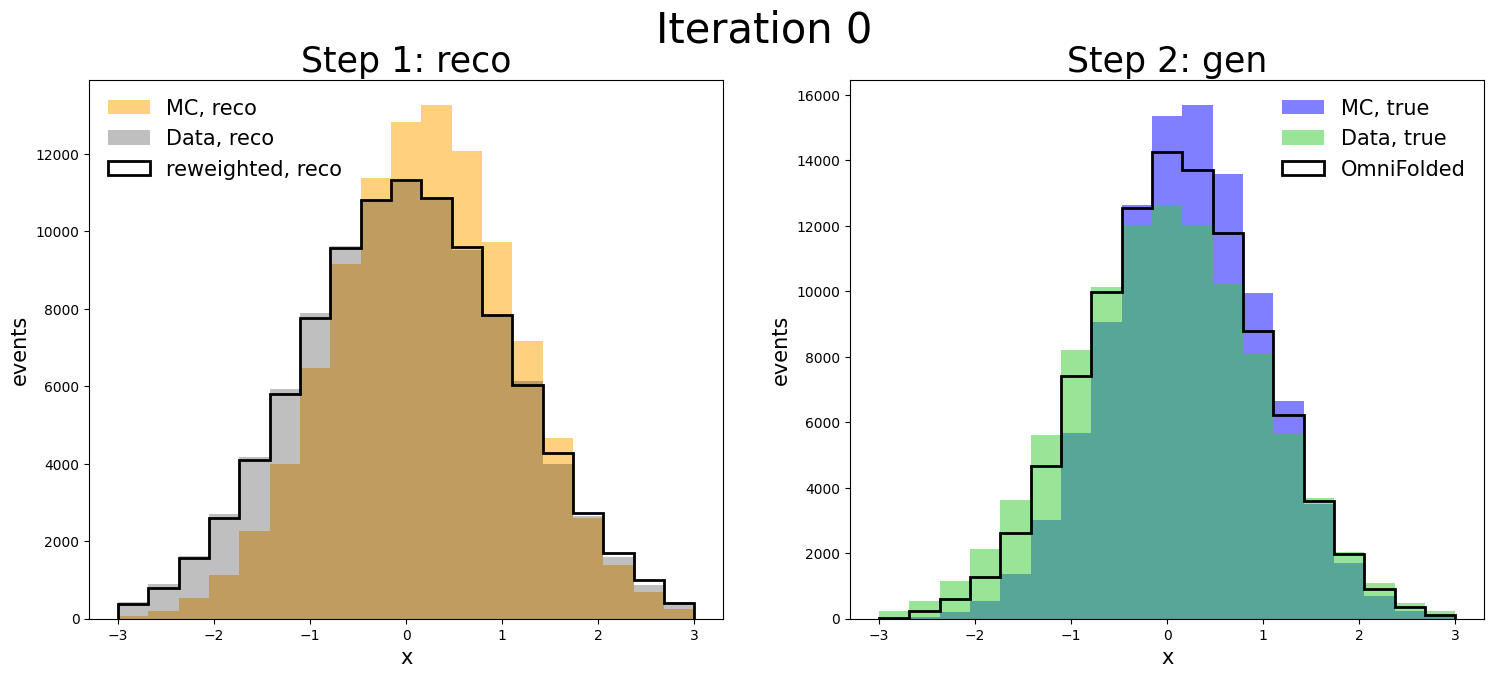

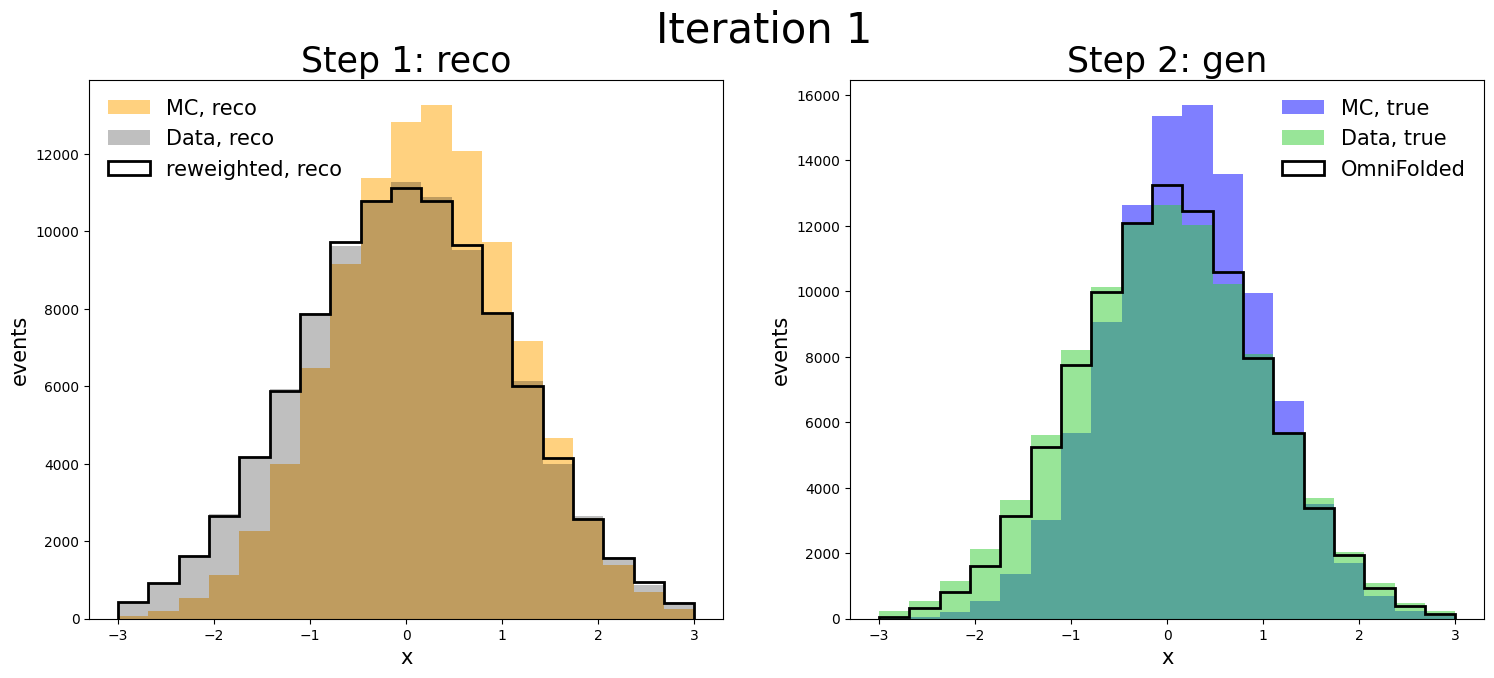

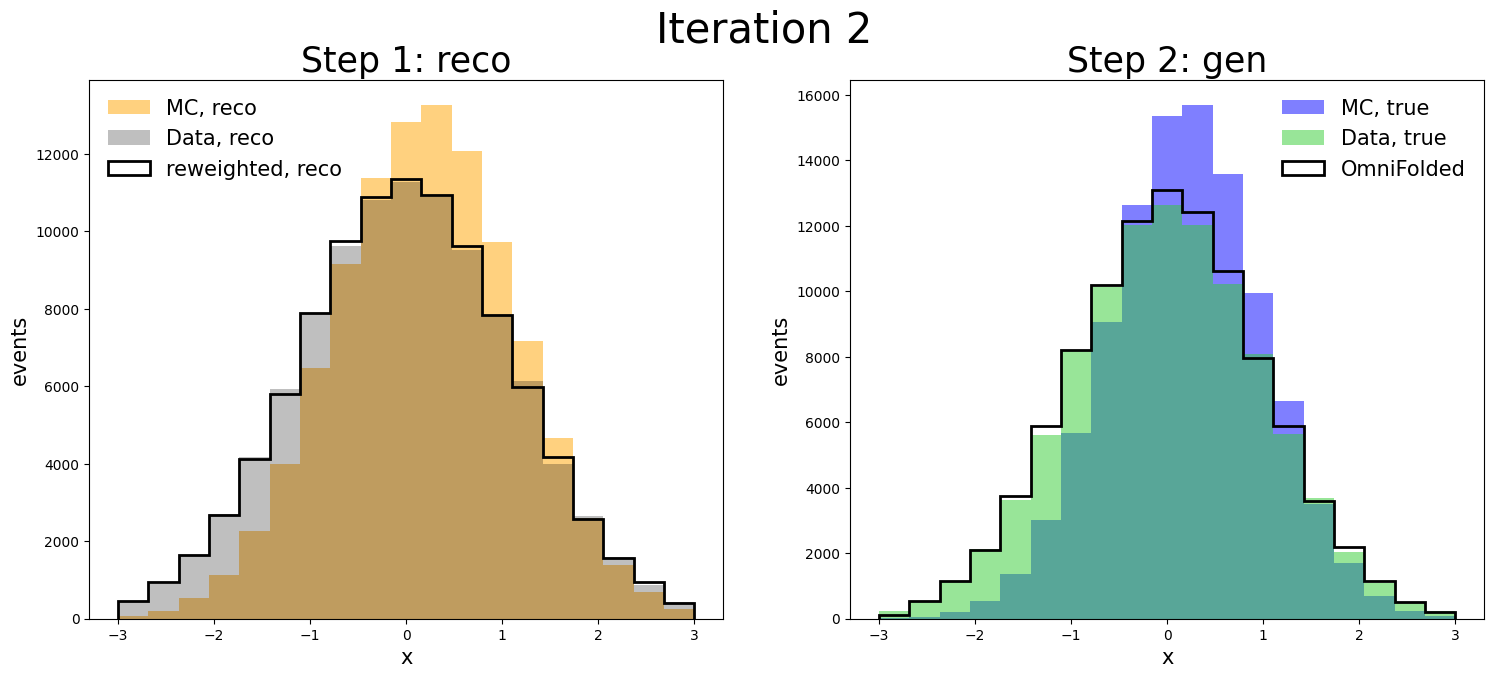

In [11]:


for i in range(N_Iterations):
    
    fig, ax = plt.subplots(1, 2, figsize=(18,7))    

    ax[0].hist(theta0_S,bins=np.linspace(-3,3,20),color='orange',label="MC, reco",alpha=0.5)
    ax[0].hist(theta_unknown_S,bins=np.linspace(-3,3,20),color='black',label="Data, reco",alpha=0.25)
    ax[0].hist(theta0_S,weights=myweights[i, 0, :], bins=np.linspace(-3,3,20),color='black',histtype="step",label="reweighted, reco",lw="2")
    ax[0].set_title("Step 1: reco",fontsize=25)
    ax[0].set_xlabel("x",fontsize=15)
    ax[0].set_ylabel("events",fontsize=15)
    ax[0].legend(frameon=False,fontsize=15)

    ax[1].hist(theta0_G,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
    ax[1].hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='limegreen',alpha=0.5,label="Data, true")
    ax[1].hist(theta0_G,weights=myweights[i, 1, :], bins=np.linspace(-3,3,20),color='black',histtype="step",label="OmniFolded",lw="2")
    ax[1].set_title("Step 2: gen", fontsize=25)
    ax[1].set_xlabel("x",fontsize=15)
    ax[1].set_ylabel("events",fontsize=15)
    ax[1].legend(frameon=False,fontsize=15)
    plt.suptitle(f"Iteration {i}",fontsize=30)

### $\rightarrow$ Increase `N_Events` to better see improvements with iteration. Can play with classifier, but perhaps for more complex distributions

___
___

# Omnifold Example 2: Z+Jet Pythia and Herwig w/ Delphes

`gen` is particle level simulation, and `sim` is detector level simulation

We (arbitrarily) choose Pythia to be our simulation, and `Herwig` to be our "data"

In [12]:
N_Events = 10**5

In [13]:
pythia = np.load("datasets/ZjetsDelphes/Pythia26_Zjet_pTZ-200GeV_0.npz") # our 'synthetic' sim
herwig = np.load("datasets/ZjetsDelphes/Herwig_Zjet_pTZ-200GeV_0.npz")   # our 'data' sim

In [14]:
print(list(pythia.keys()))
print(np.shape(pythia['gen_jets']),"\n")

print(list(herwig.keys()))
print(np.shape(herwig['sim_jets']),"\n")

['gen_Zs', 'gen_jets', 'sim_jets', 'gen_particles', 'sim_particles', 'gen_sdms', 'sim_sdms', 'gen_zgs', 'sim_zgs', 'gen_mults', 'sim_mults', 'gen_lhas', 'sim_lhas', 'gen_widths', 'sim_widths', 'gen_ang2s', 'sim_ang2s', 'gen_tau2s', 'sim_tau2s']
(100000, 4) 

['gen_Zs', 'gen_jets', 'sim_jets', 'gen_particles', 'sim_particles', 'gen_sdms', 'sim_sdms', 'gen_zgs', 'sim_zgs', 'gen_mults', 'sim_mults', 'gen_lhas', 'sim_lhas', 'gen_widths', 'sim_widths', 'gen_ang2s', 'sim_ang2s', 'gen_tau2s', 'sim_tau2s']
(100000, 4) 



### In theory, we can unfold all of the observables above _simultaneously_, but let's start with just 6!
$p_\mathrm{Tjet}$, $y_\mathrm{jet}$, $\phi_\mathrm{jet}$, $m_\mathrm{jet}$, $m_\mathrm{zg,jet}$, Mult$_\mathrm{jet}$

## Z+Jet Pythia and Herwig w/ Delphes

- `jets` - The jet axis four vector, as ($p_\mathrm{Tjet}$, $y_\mathrm{jet}$, $\phi_\mathrm{jet}$, $m_\mathrm{jet}$)

- `particles` - The rescaled jet constituents ($p_\mathrm{T}$/100,$y−y_\mathrm{jet}$,$\phi−\phi_\mathrm{jet}$, fPID)

- `mults` - The constituent multiplicity of the jet.
- `lhas` - The Les Houches (β=1/2) angularity.
- `widths` - The jet width (β=1 angularity).
- `ang2s` - The β=2 angularity (note that this is very similar to the jet mass, but does not depend on particle masses).
- `tau2s` - The 2-subjettiness with β=1.
- `sdms` - The groomed mass with Soft Drop parameters zcut=0.1 and β=0.
- `zgs` - The groomed momentum fraction (same Soft Drop parameters as above).

In [15]:
# sim
theta0_S = np.column_stack((pythia['sim_jets'], pythia['sim_zgs'], pythia['sim_mults']))
theta0_G = np.column_stack((pythia['gen_jets'], pythia['gen_zgs'], pythia['gen_mults']))


# 'data'
theta_unknown_S = np.column_stack((herwig['sim_jets'], herwig['sim_zgs'], herwig['sim_mults']))
theta_unknown_G = np.column_stack((herwig['gen_jets'], herwig['gen_zgs'], herwig['gen_mults']))

In [16]:
print(np.shape(theta_unknown_G))

(100000, 6)


## Plot the distributions before Unfolding

In [17]:
plot_reco = False

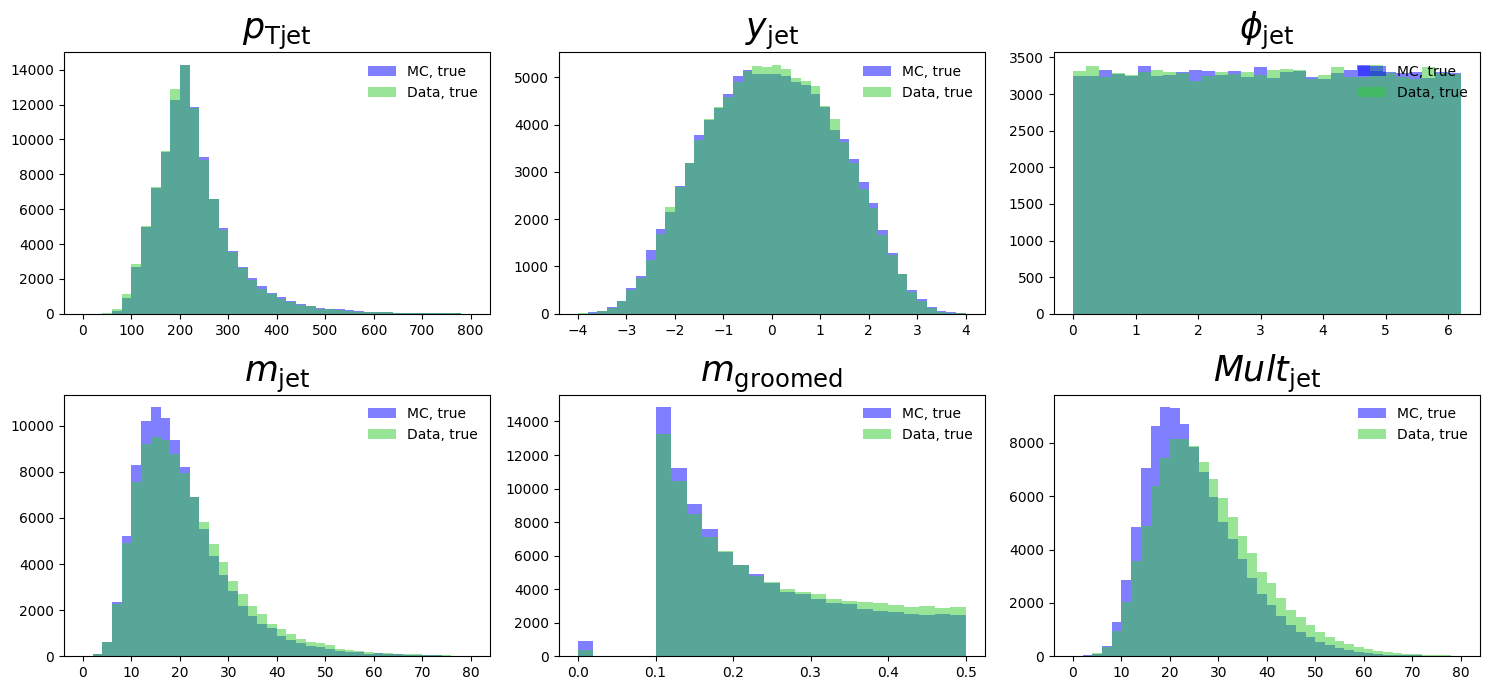

In [18]:
binning = [ #simple plotting bins
np.linspace(0, 800,  41),   #jet pT
np.linspace(-4, 4, 41),     #jet y
np.linspace(0.0, 6.2, 31),  #jet phi
np.linspace(0, 80,  41),    #jet mass
np.linspace(0, 0.5, 26),    # groomed mass
np.linspace(0, 80, 41)]     # multiplicity

labels = [
    r"$p_\mathrm{Tjet}$",
    r"$y_\mathrm{jet}$",
    r"$\phi_\mathrm{jet}$",
    r"$m_\mathrm{jet}$",
    r"$m_\mathrm{groomed}$",
    r"$Mult_\mathrm{jet}$"]
    

N = len(binning)

fig, axes = plt.subplots(2, 3, figsize=(15,7))

for i,ax in enumerate(axes.ravel()):
    if (i >= N): break
    _,_,_=ax.hist(theta0_G[:,i],binning[i],color='blue',alpha=0.5,label="MC, true")
    _,_,_=ax.hist(theta_unknown_G[:,i],binning[i],color='limegreen',alpha=0.5,label="Data, true")

    if plot_reco:
        _,_,_=ax.hist(theta0_S[:,i],binning[i],histtype="step",color='black',ls=':',label="MC, reco")
        _,_,_=ax.hist(theta_unknown_S[:,i],binning[i],color='black',label="Data, reco",alpha=0.25)

    ax.set_title(labels[i],fontsize=25)
    #ax.set_xlabel(labels[i])
    #ax.set_ylabel("Events")
    ax.legend(frameon=False)
    
fig.tight_layout()

In [19]:
inputs = Input(np.shape(theta0_G)[-1], )
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_dis = Model(inputs=inputs, outputs=outputs)

In [20]:
N_Iterations = 5

myweights = of.omnifold(theta0_G,theta0_S, theta_unknown_S, N_Iterations, model_dis)

In [38]:
print(np.shape(myweights))
print(np.shape(theta0_G))

(5, 2, 100000)
(100000, 6)


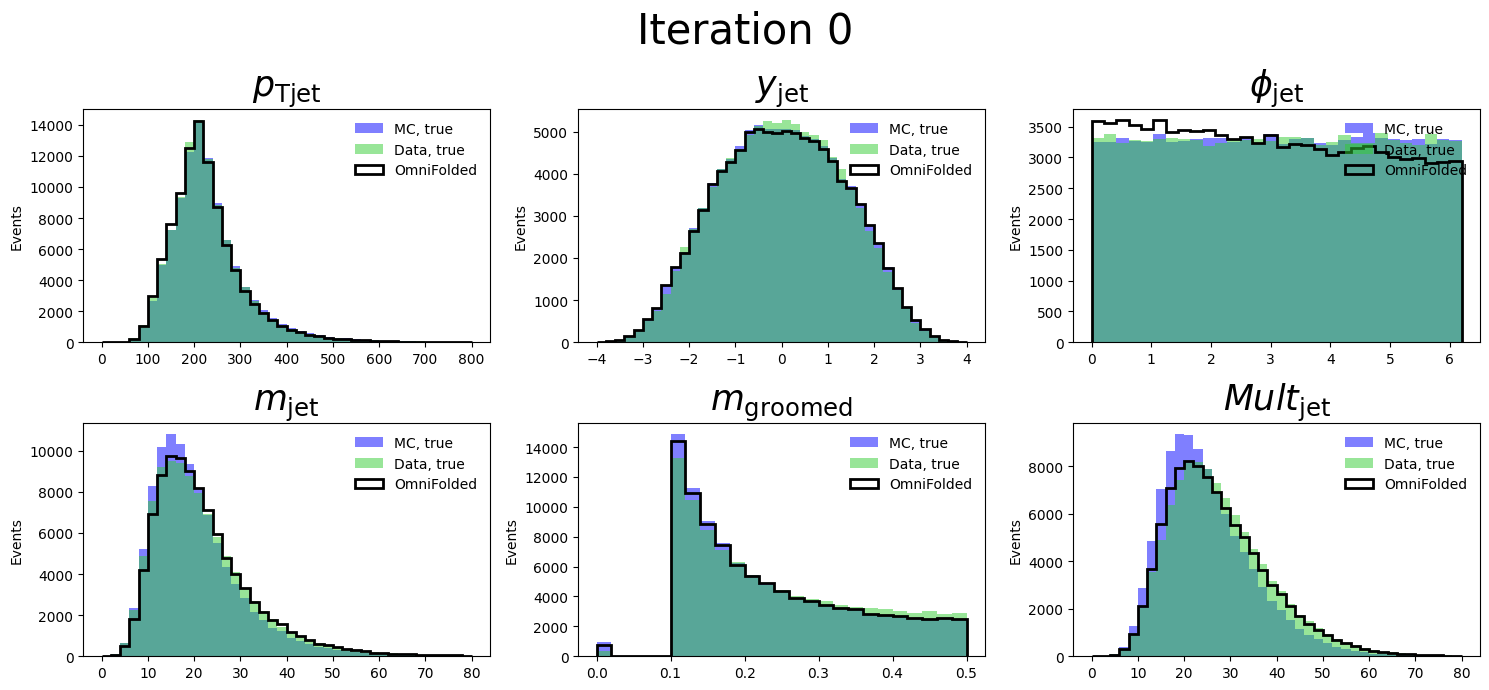

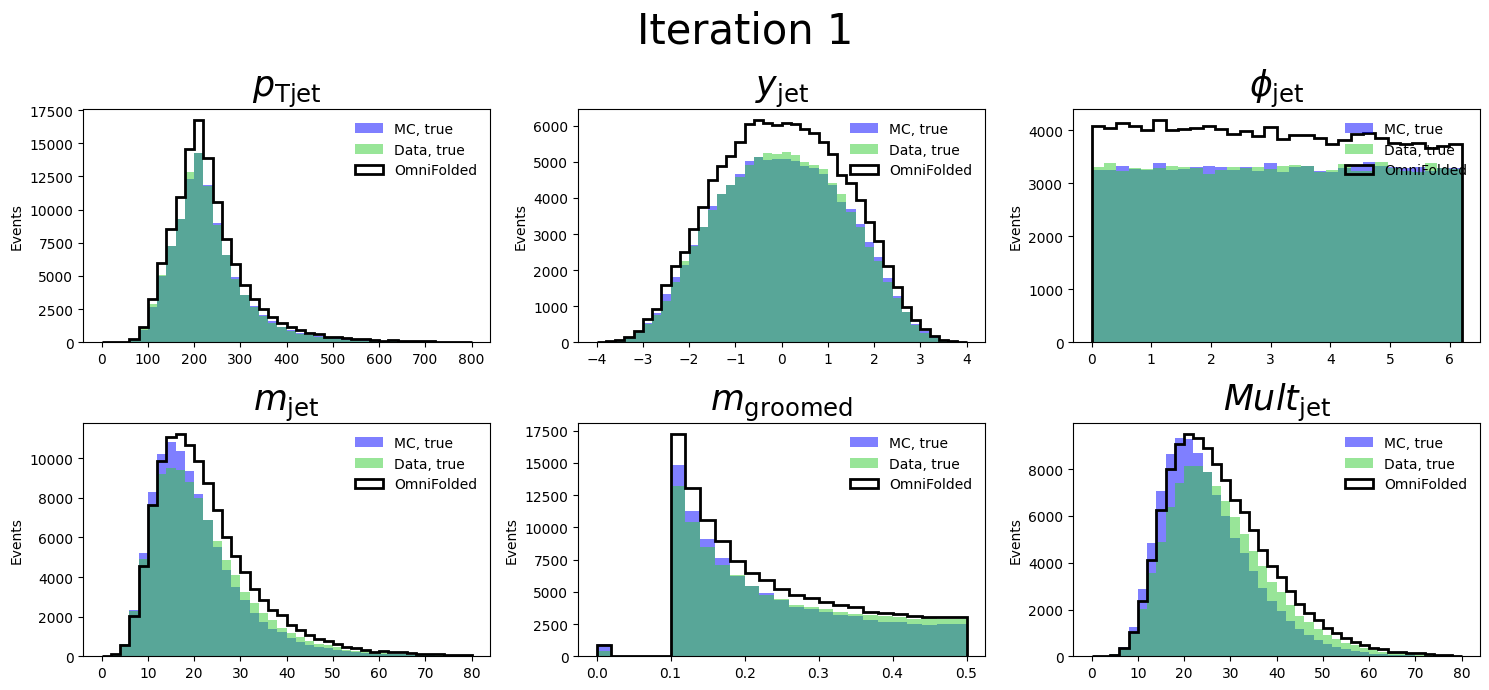

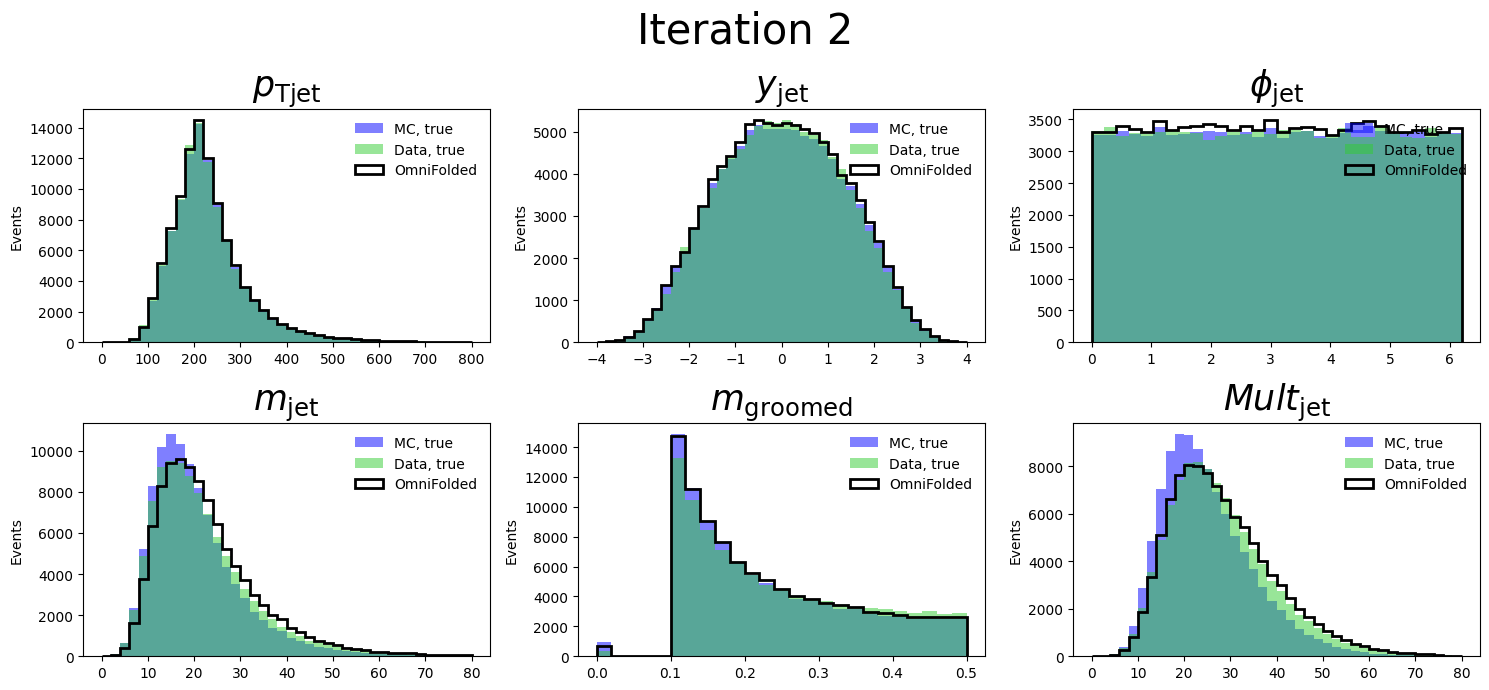

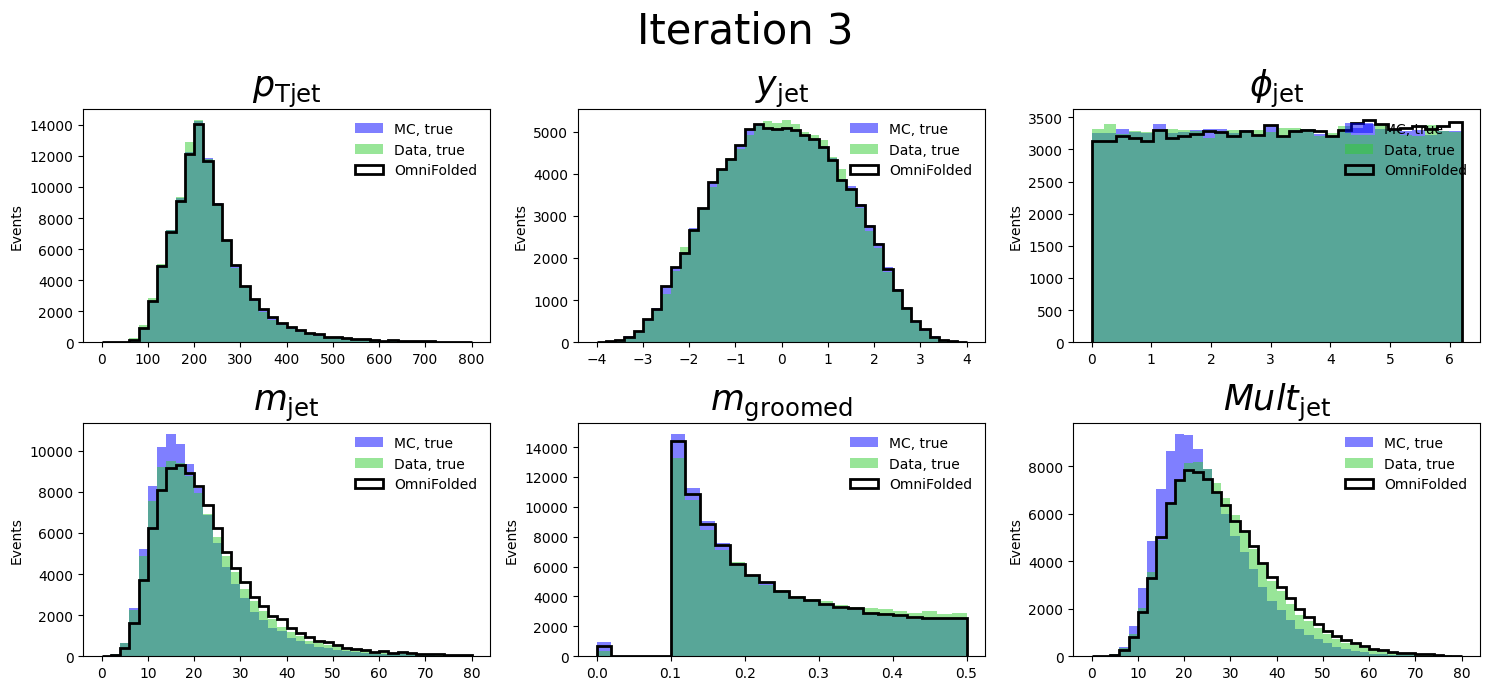

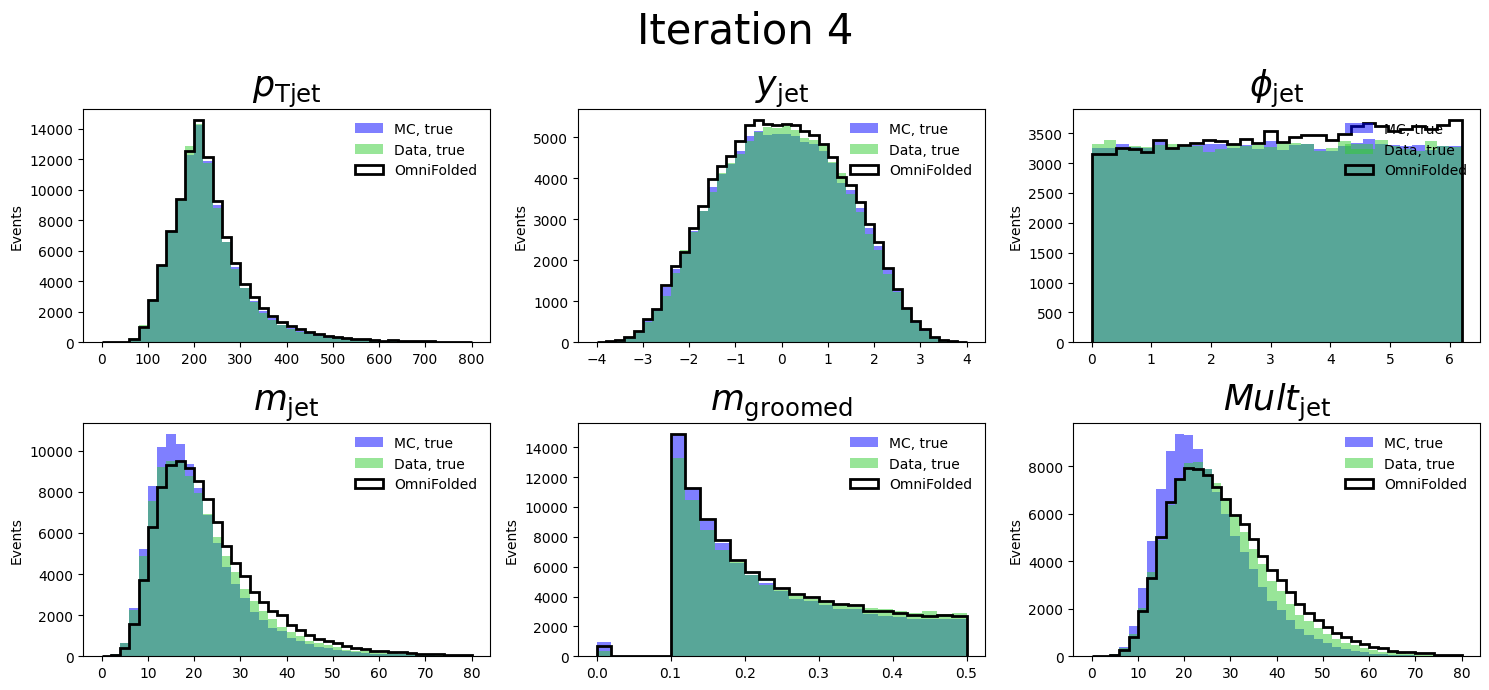

In [39]:
for it in range(N_Iterations):

    fig, axes = plt.subplots(2, 3, figsize=(15,7))

    for i,ax in enumerate(axes.ravel()):
        if (i >= N): break
        
        _,_,_=ax.hist(theta0_G[:,i],binning[i],color='blue',alpha=0.5,label="MC, true")
        _,_,_=ax.hist(theta_unknown_G[:,i],binning[i],color='limegreen',alpha=0.5,label="Data, true")
        _,_,_=ax.hist(theta0_G[:,i],weights=myweights[it, 1, :],bins=binning[i],color='black',histtype="step",label="OmniFolded",lw="2")
        #_,_,_=ax.hist(theta0_S[:,i],binning[i],histtype="step",color='black',ls=':',label="MC, reco")

        #ax.set_title(labels[i])
        #ax.set_xlabel(labels[i])
        ax.set_ylabel("Events")
        ax.legend(frameon=False)
        ax.set_title(labels[i],fontsize=25)
        
    plt.suptitle(f"Iteration {it}",fontsize=30)
    fig.tight_layout()

___
___

# OmniFold: DIY

### 1. Add Jet Features, number of events, or iterations to the unfolding
careful adding both: might take a while!

hint: append theta0 and theta_unkwonw. myweights = of.omnifold(theta0_G,theta0_S,theta_unknown_S,N_Iterations,model_dis)

### 2. Changes to the classifier? Both models are defined in the notebook

### 3. What observables can you make with the old/new jet features? Can you compare to unfolding them directly?

DIY check on reusability!